Episode 0, Total Reward: -1, Average Loss: 0
Episode 1, Total Reward: -1, Average Loss: 0
Episode 2, Total Reward: -1, Average Loss: 0.10936736911535264
Episode 3, Total Reward: 0, Average Loss: 0.08259993643463351
Episode 4, Total Reward: 0, Average Loss: 0.025804828164972635
Episode 5, Total Reward: -1, Average Loss: 0.016871284894659767
Episode 6, Total Reward: -1, Average Loss: 0.02107999027111873
Episode 7, Total Reward: 0, Average Loss: 0.023815868153299866
Episode 8, Total Reward: 0, Average Loss: 0.02255990725279844
Episode 9, Total Reward: 2, Average Loss: 0.032246951359330624
Episode 10, Total Reward: -1, Average Loss: 0.02901300669327611
Episode 11, Total Reward: -1, Average Loss: 0.028791726804316947
Episode 12, Total Reward: -1, Average Loss: 0.023087311871242255
Episode 13, Total Reward: -1, Average Loss: 0.04151865415951761
Episode 14, Total Reward: -1, Average Loss: 0.023765672229533914
Episode 15, Total Reward: -1, Average Loss: 0.03909127047817867
Episode 16, Total Re

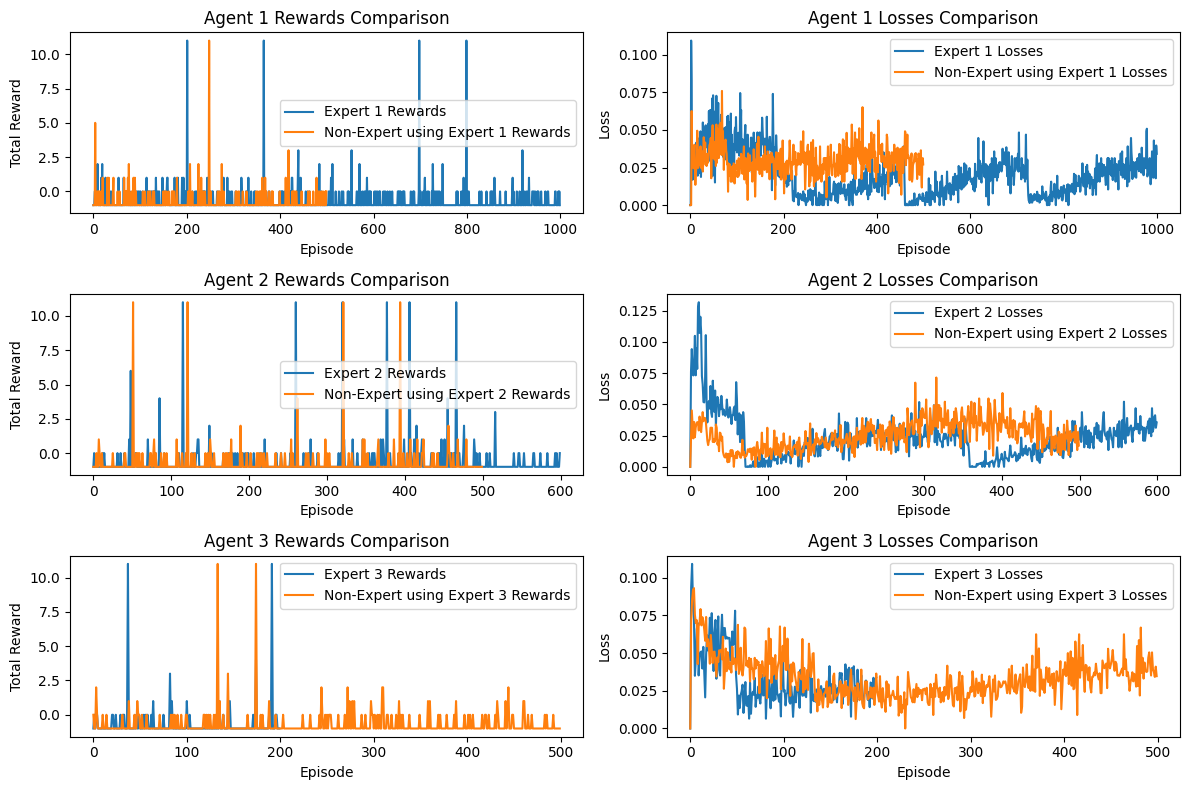

In [14]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pygame
import time
import gym
from gym import spaces

pygame.init()

class PongEnvironment(gym.Env):
    def __init__(self):
        super(PongEnvironment, self).__init__()
        self.width = 400
        self.height = 300
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, self.height // 2], dtype=float)
        self.ball_vel = np.array([5, 1], dtype=float) * 100
        self.paddle_pos = self.height // 2
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.time_step = 0
        self.start_time = time.time()
        self.tot_reward = 0
        self.ball_pos = np.array([random.randint(self.width // 4, 3 * self.width // 4), random.randint(self.height // 4, 3 * self.height // 4)], dtype=float)
        self.ball_vel = np.array([random.random(), random.random()], dtype=float) * 100
        self.paddle_pos = self.height // 2
        return self.get_state()

    def step(self, action):
        self.time_step += 1
        move = -5 if action == 0 else 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel
        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        reward = 0
        done = False
        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                self.ball_vel[0] *= -1
                reward = 1
                self.tot_reward += 1
            else:
                reward = -1
                done = True

        if self.tot_reward > 10 or time.time() - self.start_time > 30:
            done = True

        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return self.get_state(), reward, done, {}

    def move_paddle(self, move):
        self.paddle_pos = np.clip(self.paddle_pos + move, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([self.ball_pos[0] / self.width, self.ball_pos[1] / self.height, self.ball_vel[0] / 100, self.ball_vel[1] / 100, self.paddle_pos / self.height])

    def render(self, mode="human"):
        if mode == "human":
            self.screen.fill((0, 0, 0))
            pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, int(self.paddle_pos - self.paddle_height / 2), self.paddle_width, self.paddle_height))
            pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
            pygame.display.update()


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor(reward), torch.FloatTensor(next_state), torch.FloatTensor(done)

class DQN(nn.Module):
    def __init__(self, state_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

def average_weights(expert_weights):
    avg_weights = {}
    for key in expert_weights[0].keys():
        avg_weights[key] = torch.mean(torch.stack([experts[key] for experts in expert_weights]), dim=0)
    return avg_weights

def train_dqn(env, episodes=500, is_expert=False, expert_weights=None):
    state_size = env.get_state().shape[0]
    batch_size = 32
    replay_buffer = ReplayBuffer(10000)
    policy_net = DQN(state_size, 64)

    if not is_expert and expert_weights is not None:
        policy_net.load_state_dict(expert_weights)

    target_net = DQN(state_size, 64)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []

        while not done:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = torch.FloatTensor(state).unsqueeze(0)
                    action = policy_net(state_t).item()
            else:
                action = random.randint(0, 1)

            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer.buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                state_action_values = policy_net(states)
                next_state_values = target_net(next_states).detach()
                expected_state_action_values = rewards + (0.99 * next_state_values * (1 - dones))
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return rewards_per_episode, losses, policy_net

def main():
    env = PongEnvironment()
    experts_rewards = []
    experts_losses = []
    experts_weights = []
    non_expert_agents_rewards = []
    non_expert_agents_losses = []
    num_experts = 3

    # Train each expert agent and collect their rewards, losses, and weights
    episodes_per_expert = [1000, 600, 200]
    for episodes in episodes_per_expert:
        expert_rewards, expert_losses, expert_policy_net = train_dqn(env, episodes=episodes, is_expert=True)
        experts_rewards.append(expert_rewards)
        experts_losses.append(expert_losses)
        experts_weights.append(expert_policy_net.state_dict())

    # Train the non-expert agent with the weights of each expert and collect their rewards and losses
    episodes_non_expert = 500
    for i in range(num_experts):
        non_expert_rewards, non_expert_losses, _ = train_dqn(env, episodes=episodes_non_expert, is_expert=False, expert_weights=experts_weights[i])
        non_expert_agents_rewards.append(non_expert_rewards)
        non_expert_agents_losses.append(non_expert_losses)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot for each expert and corresponding non-expert agent
    for i in range(num_experts):
        plt.subplot(num_experts, 2, 2*i+1)
        plt.plot(experts_rewards[i], label=f'Expert {i+1} Rewards')
        plt.plot(non_expert_agents_rewards[i], label=f'Non-Expert using Expert {i+1} Rewards')
        plt.title(f'Agent {i+1} Rewards Comparison')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()

        plt.subplot(num_experts, 2, 2*i+2)
        plt.plot(experts_losses[i], label=f'Expert {i+1} Losses')
        plt.plot(non_expert_agents_losses[i], label=f'Non-Expert using Expert {i+1} Losses')
        plt.title(f'Agent {i+1} Losses Comparison')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
